In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('./tmp/df_cleaned.gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 6 to 6715
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            5600 non-null   object 
 1   PrimaryPropertyType     5600 non-null   object 
 2   Neighborhood            5600 non-null   object 
 3   NumberofFloors          5370 non-null   float64
 4   PropertyGFATotal        5258 non-null   float64
 5   LargestPropertyUseType  5482 non-null   object 
 6   ENERGYSTARScore         4292 non-null   float64
 7   SourceEUI(kBtu/sf)      5281 non-null   float64
 8   SiteEnergyUse(kBtu)     5400 non-null   float64
 9   TotalGHGEmissions       5600 non-null   float64
 10  GHGEmissionsIntensity   5335 non-null   float64
 11  BuildingAge             5600 non-null   int64  
 12  Distance                5600 non-null   float64
 13  NaturalGasRate          5160 non-null   float64
dtypes: float64(9), int64(1), object(4)
memor

In [4]:
# on regarde simplement quelles sont les formes des features
feats = pd.DataFrame(
	columns=['feature', 'std', 'skew', 'var', 'kur']
)
agg_func = ['std', 'skew', 'var', 'kurtosis']

for f in df.select_dtypes(['float', 'int']):
	res = df[f].agg(agg_func)
	feats = feats.append(
		{'feature' : f, 'std' : res[0], 'skew' : res[1], 'var' : res[2], 'kur': res[3]},
		ignore_index=True)

feats


,feature,std,skew,var,kur
0,NumberofFloors,1.767021e+00,0.445056,3.122362e+00,-0.237538
1,PropertyGFATotal,3.375187e+04,1.613754,1.139189e+09,2.095403
2,ENERGYSTARScore,2.625680e+01,-0.900268,6.894196e+02,-0.106955
3,SourceEUI(kBtu/sf),4.438234e+01,0.968131,1.969793e+03,0.961476
4,SiteEnergyUse(kBtu),1.777724e+06,1.598250,3.160301e+12,2.186972
5,TotalGHGEmissions,4.800313e+01,1.468106,2.304301e+03,1.507648
6,GHGEmissionsIntensity,6.821282e-01,1.468306,4.652989e-01,1.486484
7,BuildingAge,3.326957e+01,0.523466,1.106864e+03,-0.929233
8,Distance,2.219051e+00,0.803548,4.924188e+00,-0.286699
9,NaturalGasRate,2.683825e-01,0.754646,7.202919e-02,-0.637035


In [74]:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from datetime import datetime



prediction = 'TotalGHGEmissions'
removed_features= 'ENERGYSTARScore'

X = df.drop([prediction, removed_features], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


def runModel(model, params={}):
	start_time = datetime.now()
	# categorical features : they are only nominal (not cardinal),
	# thus we could encode them with OneHotEncoder (not OrdinalEncoder)
	categorical_transformer = OneHotEncoder(handle_unknown="ignore")

	numeric_transformer = Pipeline(
		steps=[
			("imputer", SimpleImputer()), 
			("minmax", MinMaxScaler()),
			("scaler", StandardScaler(with_mean=False)),
			]
	)

	preprocessor = ColumnTransformer(
		transformers=[
			("num", numeric_transformer, selector(dtype_exclude="object")),
			("cat", categorical_transformer, selector(dtype_include="object"))
		]
	)

	reg = Pipeline(
		steps=[("preprocessor", preprocessor), ("regressor", model)]
	)

	reg.fit(X_train, y_train)

	# add a parameter for imputer, for all model's grid search
	params["preprocessor__num__imputer__strategy"] = ["mean", "median"]
	
	gs = GridSearchCV(
		estimator=reg, 
		cv=5, 
		param_grid=params,
		scoring=('r2','neg_mean_absolute_error'),
		refit='r2',
		return_train_score = True,
		n_jobs=-1
		)
		
	gs.fit(X_train, y_train)
	end_time = datetime.now()
	
	ellapsed_time = (end_time - start_time).total_seconds()
	y_pred = gs.predict(X_test)
		
	ret = {
		'model' : type(model).__name__,
		'compute_time' : ellapsed_time,
		'best_params' : gs.best_params_,
		'RMSE' : np.sqrt(mean_squared_error(y_pred, y_test)),
		'MAE' : mean_absolute_error(y_pred, y_test),
		'R2' : r2_score(y_pred, y_test),
		'cv_results' : gs.cv_results_,
		'model_train_score' : gs.score(X_train, y_train),
		'model_test_score' : gs.score(X_test, y_test)
	}

	# TODO print validation curve : https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

	return ret	





In [75]:

# Dummy regressor as a baseline / test
runModel(DummyRegressor(strategy="mean"))



{'model': 'DummyRegressor',
 'compute_time': 0.115533,
 'best_params': {'preprocessor__num__imputer__strategy': 'mean'},
 'RMSE': 46.015526280841634,
 'MAE': 35.976654284917096,
 'R2': -1.0484998868744623e+31,
 'cv_results': {'mean_fit_time': array([0.01143641, 0.01796923]),
  'std_fit_time': array([0.00219087, 0.00057669]),
  'mean_score_time': array([0.0044806, 0.0067255]),
  'std_score_time': array([0.00104144, 0.00034402]),
  'param_preprocessor__num__imputer__strategy': masked_array(data=['mean', 'median'],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'preprocessor__num__imputer__strategy': 'mean'},
   {'preprocessor__num__imputer__strategy': 'median'}],
  'split0_test_r2': array([-1.23275475e-05, -1.23275475e-05]),
  'split1_test_r2': array([-0.00582266, -0.00582266]),
  'split2_test_r2': array([-0.00130695, -0.00130695]),
  'split3_test_r2': array([-0.01015007, -0.01015007]),
  'split4_test_r2': array([-0.00027295, -0.00

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from xgboost import XGBRegressor
import os
from dataclasses import dataclass
from datetime import datetime

xgb.set_config(verbosity=0)

@dataclass
class ModelCompute:
    model: object
    params: dict


parameters_svr = {
	'regressor__C' : np.logspace(-2, -1, 10),
	'regressor__loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

parameters_rf = {
			'regressor__n_estimators' : [10,50,100,300,500],
			'regressor__min_samples_leaf' : [1,3,5,10], 
			'regressor__max_features': ['auto', 'sqrt', 'log2'],
			# 'regressor__max_depth' : [5, 15, 25, 50],
			# 'regressor__min_samples_split': [2, 5, 10],
            # 'regressor__bootstrap' : [True, False],
		}

parameters_knn = {
	'regressor__n_neighbors' : [2, 4, 8, 10, 16]
}

parameters_xgb = {
	'regressor__n_estimators' : [200, 500, 1000],
	'regressor__max_depth' : [2, 5, 10],
	'regressor__eval_metric' : ["rmse"],

}

parameters_ridge = {
	'regressor__alpha' : np.logspace(-5, 5, 100)
}

parameters_lasso = {
	'regressor__alpha' : np.logspace(-5, 5, 50)
}

parameters_net = {
	'regressor__alpha' : np.logspace(-5, 5, 50),
	# 'regressor__l1_ratio' : np.logspace(-5, 5, 200),
}

models = [
	# ModelCompute(DummyRegressor(strategy="mean"), {}),
	ModelCompute(LinearRegression(), {}),
	ModelCompute(KNeighborsRegressor(), parameters_knn),
	ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf),
	# ModelCompute(XGBRegressor(n_jobs=os.cpu_count()), parameters_xgb),
	ModelCompute(LinearSVR(), parameters_svr),
	ModelCompute(Ridge(), parameters_ridge),
	ModelCompute(Lasso(tol=1000), parameters_lasso),
	ModelCompute(ElasticNet(tol=1000), parameters_net)
]

results = pd.DataFrame(
	columns=['model', 'compute_time','best_params','RMSE','MAE','R2', 'cv_results', 'model_train_score', 'model_test_score']
	)

print(f'computing models with {os.cpu_count()} cpus')

start_time = datetime.now()
for mod in models:
	print(f'computing model {type(mod.model).__name__}...', end='')
	ret = runModel(mod.model, mod.params)
	results = results.append(ret, ignore_index=True)
	print('done.')
print(f'finished compute models in {datetime.now() - start_time}')

results.T

computing models with 32 cpus
computing model LinearRegression...done.
computing model KNeighborsRegressor...done.
computing model RandomForestRegressor...done.
computing model LinearSVR...done.
computing model Ridge...done.
computing model Lasso...done.
computing model ElasticNet...done.
finished compute models in 0:01:46.189858


,0,1,2,3,4,5,6
model,LinearRegression,KNeighborsRegressor,RandomForestRegressor,LinearSVR,Ridge,Lasso,ElasticNet
compute_time,1.060902,6.158467,92.035285,0.659529,2.408401,1.199658,1.188414
best_params,{'preprocessor__num__imputer__strategy': 'mean'},{'preprocessor__num__imputer__strategy': 'mean...,{'preprocessor__num__imputer__strategy': 'medi...,{'preprocessor__num__imputer__strategy': 'mean...,{'preprocessor__num__imputer__strategy': 'mean...,{'preprocessor__num__imputer__strategy': 'mean...,{'preprocessor__num__imputer__strategy': 'mean...
RMSE,26.050272,20.252174,10.093917,26.280135,26.308763,29.691351,29.695196
MAE,15.984306,10.620636,3.163279,16.028742,16.043145,18.464004,18.659131
R2,0.537492,0.759844,0.948166,0.509141,0.506756,0.310036,0.313473
cv_results,"{'mean_fit_time': [0.0506749153137207, 0.05273...","{'mean_fit_time': [0.0221282958984375, 0.02113...","{'mean_fit_time': [0.33750004768371583, 2.5058...","{'mean_fit_time': [0.023077678680419923, 0.023...","{'mean_fit_time': [0.028421783447265626, 0.030...","{'mean_fit_time': [0.014365053176879883, 0.020...","{'mean_fit_time': [0.017621183395385744, 0.015..."
model_train_score,0.681207,0.888871,0.993415,0.670985,0.67039,0.593277,0.593931
model_test_score,0.678109,0.805452,0.951671,0.672403,0.671689,0.581838,0.58173


In [115]:
results

,model,compute_time,best_params,RMSE,MAE,R2,cv_results,model_train_score,model_test_score
0,LinearRegression,1.060902,{'preprocessor__num__imputer__strategy': 'mean'},26.050272,15.984306,0.537492,"{'mean_fit_time': [0.0506749153137207, 0.05273...",0.681207,0.678109
1,KNeighborsRegressor,6.158467,{'preprocessor__num__imputer__strategy': 'mean...,20.252174,10.620636,0.759844,"{'mean_fit_time': [0.0221282958984375, 0.02113...",0.888871,0.805452
2,RandomForestRegressor,92.035285,{'preprocessor__num__imputer__strategy': 'medi...,10.093917,3.163279,0.948166,"{'mean_fit_time': [0.33750004768371583, 2.5058...",0.993415,0.951671
3,LinearSVR,0.659529,{'preprocessor__num__imputer__strategy': 'mean...,26.280135,16.028742,0.509141,"{'mean_fit_time': [0.023077678680419923, 0.023...",0.670985,0.672403
4,Ridge,2.408401,{'preprocessor__num__imputer__strategy': 'mean...,26.308763,16.043145,0.506756,"{'mean_fit_time': [0.028421783447265626, 0.030...",0.670390,0.671689
5,Lasso,1.199658,{'preprocessor__num__imputer__strategy': 'mean...,29.691351,18.464004,0.310036,"{'mean_fit_time': [0.014365053176879883, 0.020...",0.593277,0.581838
6,ElasticNet,1.188414,{'preprocessor__num__imputer__strategy': 'mean...,29.695196,18.659131,0.313473,"{'mean_fit_time': [0.017621183395385744, 0.015...",0.593931,0.581730


In [118]:
results.to_pickle('tmp/results.gzip')

In [119]:
result = results.set_index('model')

<AxesSubplot:xlabel='model', ylabel='r2 prediction score'>

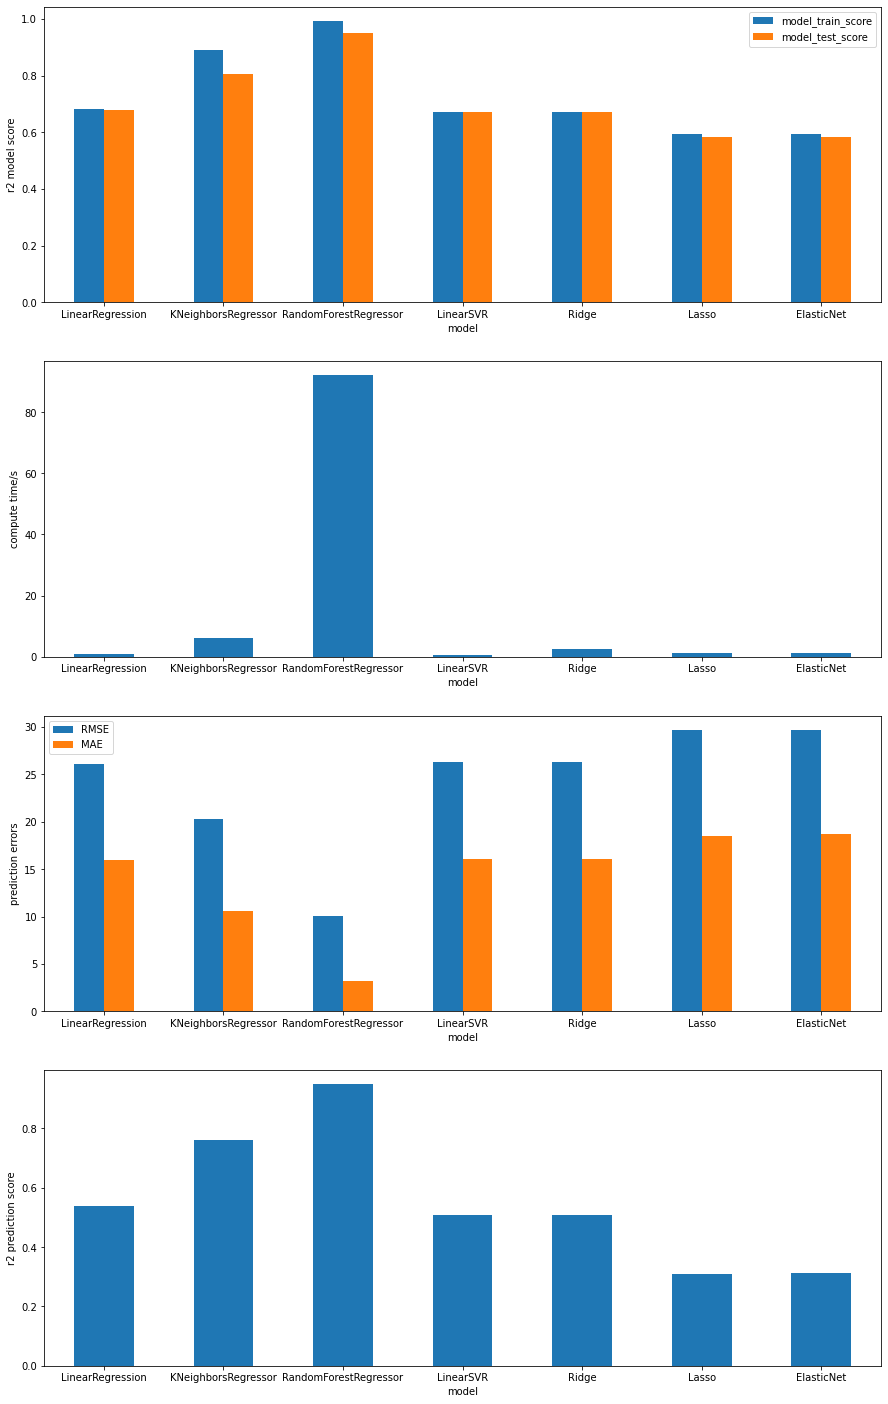

In [120]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15, 25))

result[['model_train_score', 'model_test_score']].plot(rot=0, kind='bar', ylabel='r2 model score', ax=ax0)
result['compute_time'].plot(rot=0, kind='bar', ylabel='compute time/s', ax=ax1)
result[['RMSE', 'MAE']].plot(rot=0, kind='bar', ylabel='prediction errors',  ax=ax2)
result['R2'].plot(rot=0, kind='bar', ylabel='r2 prediction score',  ax=ax3)


In [111]:
np.var(X_train)

NumberofFloors           3.090380e+00
PropertyGFATotal         1.167739e+09
SourceEUI(kBtu/sf)       1.979859e+03
SiteEnergyUse(kBtu)      3.238538e+12
GHGEmissionsIntensity    4.696760e-01
BuildingAge              1.111329e+03
Distance                 4.917338e+00
NaturalGasRate           7.180288e-02
dtype: float64

<AxesSubplot:>

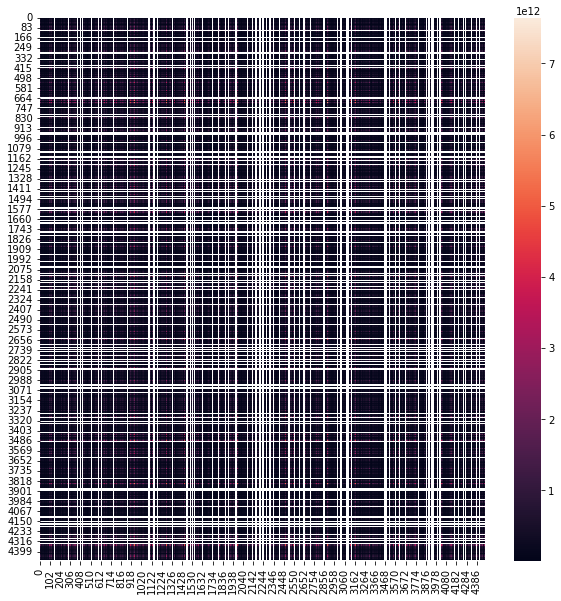

In [121]:
plt.figure(figsize=(10,10))
sns.heatmap(np.cov(X_train[X_train.select_dtypes(exclude='object').columns]))

Reading list : 

https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94

https://en.wikipedia.org/wiki/Multicollinearity

https://en.wikipedia.org/wiki/Ordinary_least_squares

https://en.wikipedia.org/wiki/Occam%27s_razor

https://en.wikipedia.org/wiki/Minimum_description_length

https://towardsdatascience.com/features-correlations-data-leakage-confounded-features-and-other-things-that-can-make-your-deep-771bcaf84f9f

https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables

https://machinelearningmastery.com/data-leakage-machine-learning/

https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html


data leakage, à cause de la corrélation entre features, le fait de bouger un peu une feature, va non seulement influencer le resultat mais aussi les features elles memes, donc la prédiction sera plus aléatoire

scaling, normalisation, : à ne faire que sur le train set

transformation : à faire sur train et test set




**1. Avancées de l’étudiant sur son projet depuis la dernière session**

Vincent a bien avancé sur le P3; il a effectué le nettoyage de données il est sur la fin.

- Test de plusieurs modèles et benchmark

**2. Principaux sujets abordés pendant la session, obstacles à surmonter (le cas échéant), et actions nécessaires pour atteindre ces objectifs**

Balayage des modèles effectués

- Random Forrest est le meilleur
- XgBoost
- Dummy
- LinearRegression

Correlations à isoler pour éviter le leakage

Passage au log et checker l'impact

StandardScaler - MinMax

**3. Objectifs 'SMART' fixés par l'étudiant et le mentor pour la prochaine session**

- Plusieurs scores RMSE - MSE - R2
- Graphiques sur les resultats des differents modèles
- Avoir une approche iterative sur le travail sur les données
- Ajouter le temps de calcul comme choix de decision
- Analyser les résultats par topologie de bâtiments
    - Surface
    - Etages
    - Type de bâtiments
- Passage au log
- Ajouter les variables catégorielles

very important article why to normalize features:
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94


In [ ]:
df.var().round(2)

NumberofFloors           3.120000e+00
PropertyGFATotal         1.139189e+09
ENERGYSTARScore          6.894200e+02
SourceEUI(kBtu/sf)       1.969790e+03
SiteEnergyUse(kBtu)      3.160301e+12
TotalGHGEmissions        2.304300e+03
GHGEmissionsIntensity    4.700000e-01
BuildingAge              1.106860e+03
Distance                 4.920000e+00
NaturalGasRate           7.000000e-02
dtype: float64

In [ ]:
df.skew().round(2)

NumberofFloors           0.45
PropertyGFATotal         1.61
ENERGYSTARScore         -0.90
SourceEUI(kBtu/sf)       0.97
SiteEnergyUse(kBtu)      1.60
TotalGHGEmissions        1.47
GHGEmissionsIntensity    1.47
BuildingAge              0.52
Distance                 0.80
NaturalGasRate           0.75
dtype: float64

certaines features ne suivent pas des distributions normales, mais on peut les transformer pour y parvenir: 

TODO : remove negative values (PropertyGFABuilding, for inst.)

IndexError: index 2 is out of bounds for axis 1 with size 2

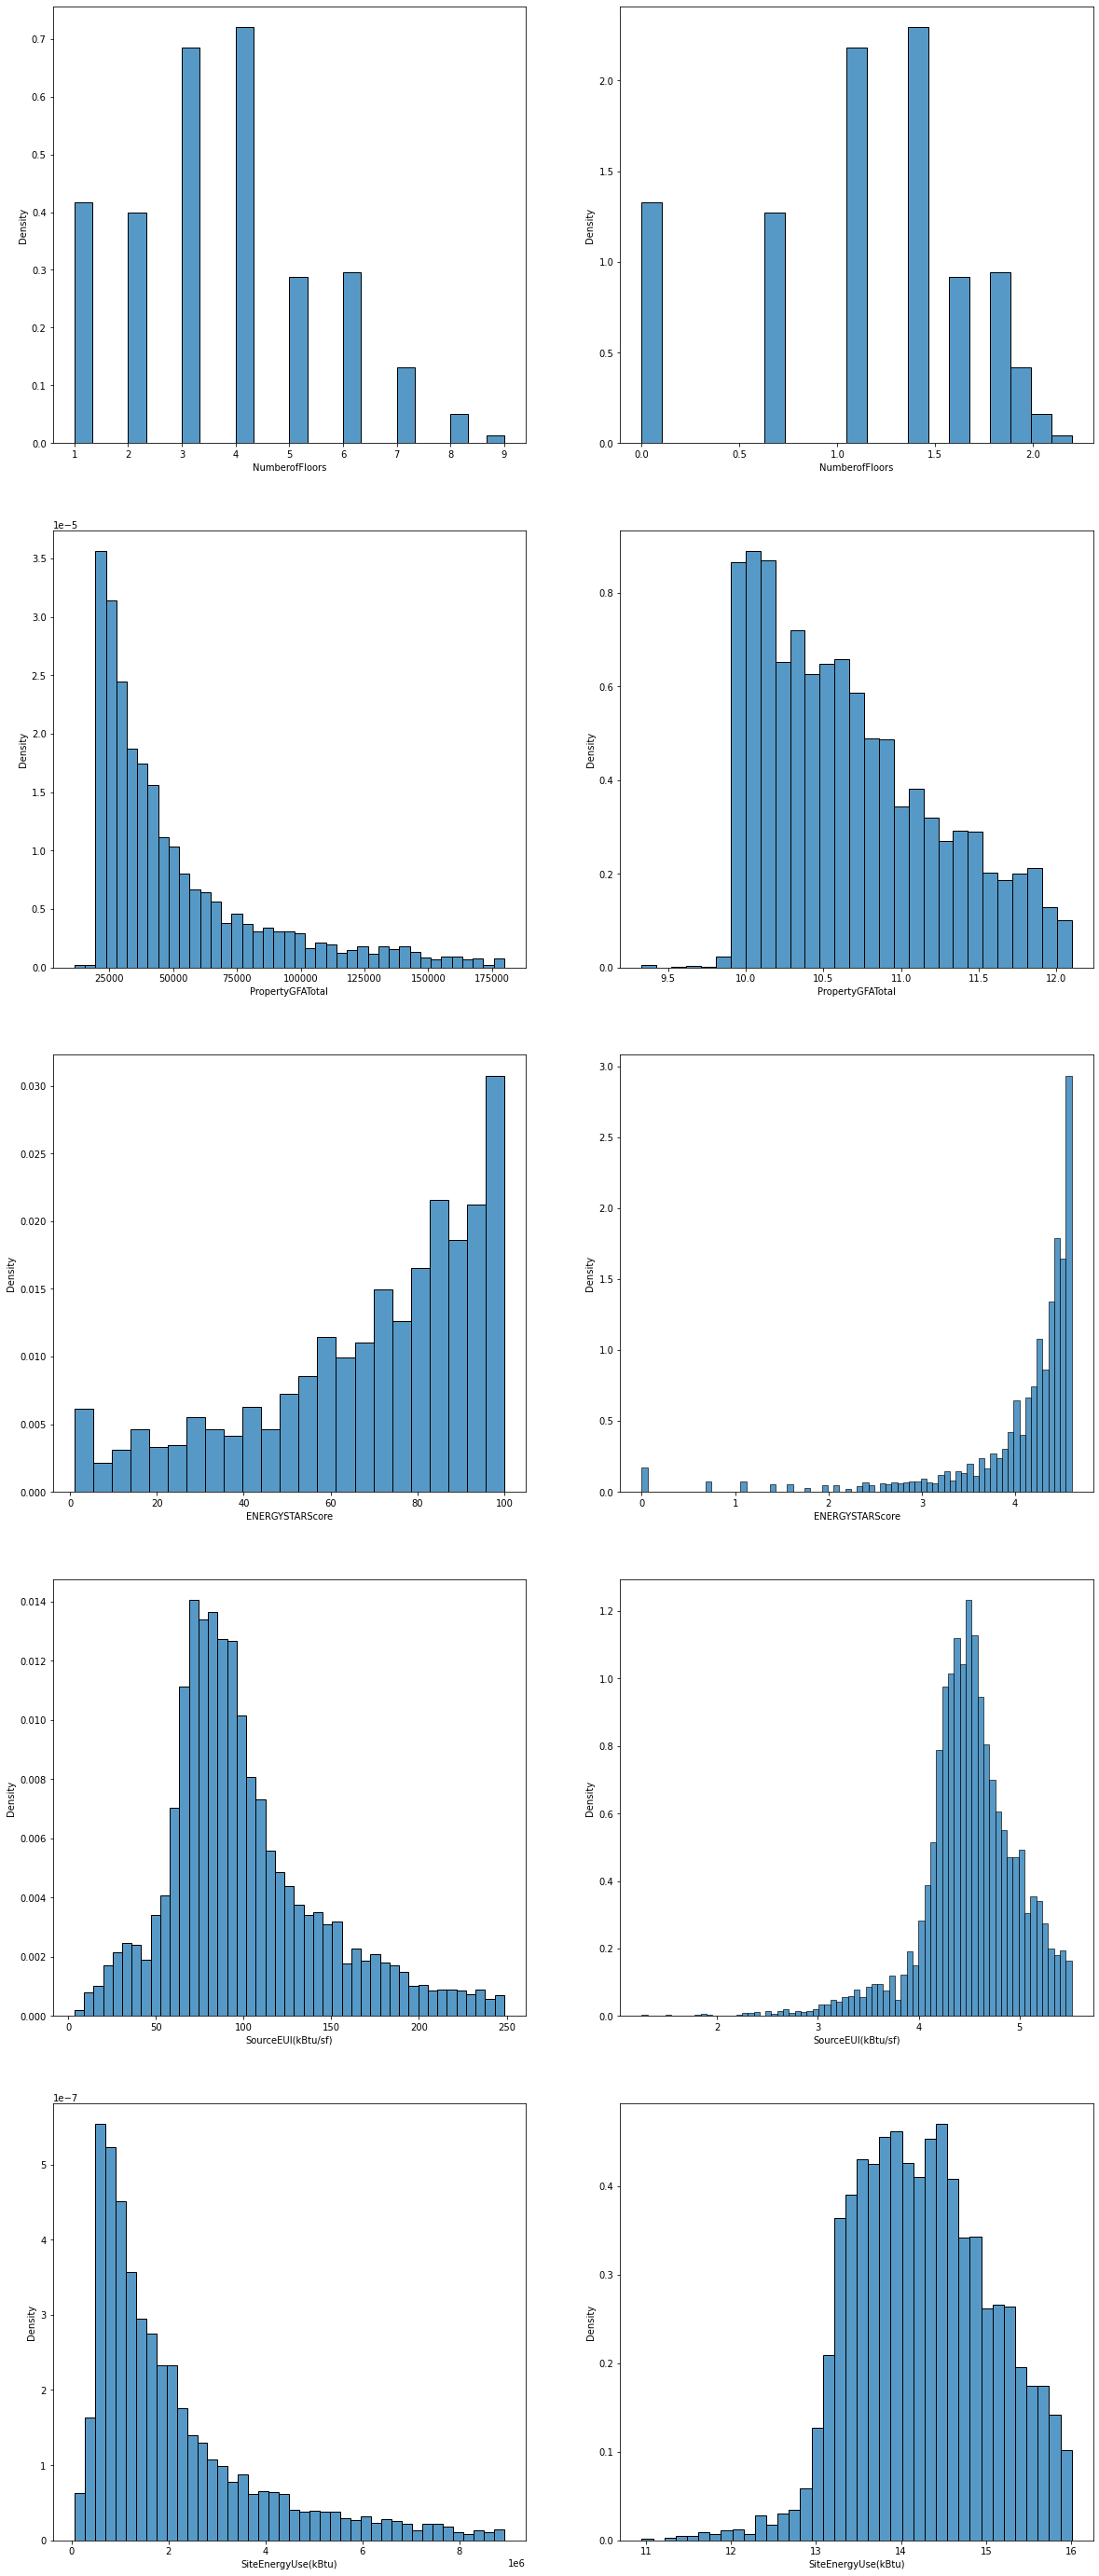

In [ ]:
from sklearn.preprocessing import FunctionTransformer
# on regarde le resultat du passage au log pour certaines features, si cela permet d'avoir une distribution normale
# TODO WIP

to_log_features = df.select_dtypes(['float', 'int']).columns
size = to_log_features.shape[0]

nrows = int(size/2)
ncols = int(size/4)
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(20,50))

for i, col in enumerate(to_log_features):
	logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
	y_log = logtransformer.transform(df[col])

	# print(f'ploting first on ({i%nrows},{ i//nrows * 2}), second on ({i%nrows},{1 + i//nrows * 2})')
	
	sns.histplot(data=df[col], stat="density", ax=ax[i%nrows, i//nrows * 2])#.set_title(col)
	# ax[0].set_title("Without log")
	
	sns.histplot(data=y_log, stat="density", ax=ax[i%nrows, 1 + i//nrows * 2])#.set_title(f'{col}-log')
	# ax[1].set_title("With log")

plt.show()